# Problem statement : Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

<img src="2.jpg">

# Bounding Box. 
In object detection, we usually use a bounding box to describe the target location. The bounding box is a rectangular box that can be determined by the x and y axis coordinates in the upper-left corner and the x and y axis coordinates in the lower-right corner of the rectangle

# Bounding Boxes for Object Detection & Classification. 
2D Bounding Boxes is perhaps the most ubiquitous annotation type one might encouter in computer vision. As the name suggests, the annotator is asked to draw a box over the objects of interest based on the requirements of the client.

In [131]:
!ls -l

total 74764
drwx------ 4 root   root     4096 Jan 12 05:56 drive
drwxr-xr-x 1 root   root     4096 Dec 18 16:52 sample_data
drwxr-xr-x 3 345018 5000     4096 Feb  1  2018 ssd_mobilenet_v1_coco_2018_01_28
-rw-r--r-- 1 root   root 76541073 Feb 10  2018 ssd_mobilenet_v1_coco_2018_01_28.tar.gz


In [132]:
#Mount Google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [133]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import the necessary libraries

In [0]:
import pandas as pd
import numpy as np
np.random.seed(1)
from matplotlib import pyplot as plt
import cv2
from sklearn import preprocessing
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input

In [0]:
!pip install patool
import patoolib
patoolib.extract_archive("/content/drive/My Drive/Projects/R10 Advanced Computer Vision/images_racoon-1.rar", outdir="/content/drive/My Drive/Projects/R10 Advanced Computer Vision/")

### Change directory

In [135]:

df = pd.read_csv('/content/drive/My Drive/Projects/R10 Advanced Computer Vision/train_labels.csv')
df.head(5)




,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


In [0]:
grouped = df.groupby('filename')

In [137]:

grouped.apply(lambda x: len(x)).value_counts()

1    148
2     11
3      1
dtype: int64

In [138]:
#How many object across all images
df.shape

(173, 8)

In [139]:
#List of labels
df['class'].unique()

array(['raccoon'], dtype=object)

In [140]:
#Number of labels
len(df['class'].unique())

1

In [141]:
#Label Encode class and add a 'label' column to the dataframe
le = preprocessing.LabelEncoder()
df['label'] = le.fit_transform(df['class'])
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,label
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118,0
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431,0
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290,0
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298,0
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127,0


In [142]:
#unique values in the label
df.label.unique()

array([0])

In [143]:
#Object detection API expects index to start from 1 (and not 0)
df['label'] = df['label'] + 1
df.label.unique()

array([1])

In [144]:
#Dataframe should have label column now
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,label
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118,1
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431,1
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290,1
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298,1
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127,1


In [145]:
#Create a dictionary of Label and Class. This will be useful for building our second input to Model training
label_class_dict = dict(zip(df['label'], df['class']))
label_class_dict

{1: 'raccoon'}

In [146]:
#Get information on all images
all_classes = df['filename'].unique()
all_classes.shape

(160,)

In [0]:
#Split images between training and test


#80% of the data will be used for training
mask = np.random.rand(all_classes.shape[0]) < 0.8

#Get Training and Test images
train_images = all_classes[mask]
test_images = all_classes[~mask] 

In [148]:
#Check number of images in training and test
train_images.shape, test_images.shape

((126,), (34,))

In [0]:
#Split dataframe between training and test
train_df = df[df['filename'].isin(train_images)]
test_df = df[df['filename'].isin(test_images)]

### Print the shape of the train dataset

In [150]:
train_df.shape, test_df.shape

((137, 9), (36, 9))

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128 

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
import csv
with open('/content/drive/My Drive/Projects/R10 Advanced Computer Vision/train_labels.csv','r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile) - 1, 4))
    spamreader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(spamreader, None)
    for i,row in enumerate(spamreader):
        #print(row)
        for j, r in enumerate(row): # Parse row with seven entities
            #print(i)
            if((j!= 0) & (j!=3)):
                row[j] = int(r)
            
        #print(row)      
        path, width, height, class_, xmin, ymin, xmax, ymax = row
        paths.append(path)
        #print(i)
        coords[i,0] = xmin * IMAGE_SIZE / width
        coords[i,1] = ymin * IMAGE_SIZE / height
        coords[i,2] = xmax * IMAGE_SIZE / width # Normalize bounding box by image size
        coords[i,3] = ymax * IMAGE_SIZE / height

In [153]:
paths

['raccoon-17.jpg',
 'raccoon-11.jpg',
 'raccoon-63.jpg',
 'raccoon-63.jpg',
 'raccoon-60.jpg',
 'raccoon-69.jpg',
 'raccoon-180.jpg',
 'raccoon-200.jpg',
 'raccoon-141.jpg',
 'raccoon-19.jpg',
 'raccoon-84.jpg',
 'raccoon-124.jpg',
 'raccoon-182.jpg',
 'raccoon-111.jpg',
 'raccoon-91.jpg',
 'raccoon-79.jpg',
 'raccoon-93.jpg',
 'raccoon-20.jpg',
 'raccoon-42.jpg',
 'raccoon-139.jpg',
 'raccoon-58.jpg',
 'raccoon-71.jpg',
 'raccoon-183.jpg',
 'raccoon-1.jpg',
 'raccoon-169.jpg',
 'raccoon-82.jpg',
 'raccoon-4.jpg',
 'raccoon-101.jpg',
 'raccoon-10.jpg',
 'raccoon-166.jpg',
 'raccoon-184.jpg',
 'raccoon-38.jpg',
 'raccoon-120.jpg',
 'raccoon-142.jpg',
 'raccoon-149.jpg',
 'raccoon-51.jpg',
 'raccoon-43.jpg',
 'raccoon-123.jpg',
 'raccoon-66.jpg',
 'raccoon-9.jpg',
 'raccoon-178.jpg',
 'raccoon-47.jpg',
 'raccoon-167.jpg',
 'raccoon-54.jpg',
 'raccoon-77.jpg',
 'raccoon-155.jpg',
 'raccoon-89.jpg',
 'raccoon-153.jpg',
 'raccoon-179.jpg',
 'raccoon-115.jpg',
 'raccoon-64.jpg',
 'raccoon-56

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

# Transfer learning 
Transfer learning is a research problem in machine learning that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. For example, knowledge gained while learning to recognize cars could apply when trying to recognize trucks. Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.Common examples of transfer learning in deep learning.

In [0]:
batch_images=np.zeros((len(paths),IMAGE_SIZE,IMAGE_SIZE,3),dtype=np.float32)

In [0]:
for i,x in enumerate(paths):
  img=Image.open('/content/drive/My Drive/Projects/R10 Advanced Computer Vision/images/'+ x)
  img=img.resize((IMAGE_SIZE,IMAGE_SIZE))
  img=img.convert('RGB')
  batch_images[i]=preprocess_input(np.array(img,dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

# MobileNets are small, low-latency, low-power models parameterized to meet the resource constraints of a variety of use cases. They can be built upon for classification, detection, embeddings and segmentation similar to how other popular large scale models, such as Inception, are used.

In [0]:
model=MobileNet(input_shape=(128,128,3),include_top=False,alpha=1.0)

In [0]:
for layer in model.layers:
  layer.trainable=False

In [0]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Reshape
x=model.layers[-1].output
x=Conv2D(4,kernel_size=4) (x)
x=Reshape((4,))(x)




### Define a custom loss function IoU which calculates Intersection Over Union

# Intersection over Union. The IoU is the ratio of the overlapping area of ground truth and predicted area to the total area. Here is a visual explanation of the metric: The two squares represent the bounding boxes of ground truth and predictions.

<img src="1.png">

In [159]:
from keras.models import Model
model=Model(input=model.input,output=x)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`
  


In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [162]:
from keras.backend import epsilon
gt = coords
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

#checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", verbose=1, save_best_only=True,
#                              save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
#stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
#reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

model.fit(batch_images,gt,
            epochs=30,batch_size = 32,
            verbose=1)


Epoch 1/30
173/173 [==============================] - 6s 36ms/step - loss: 3131.3511 - IoU: 0.0921
Epoch 2/30
173/173 [==============================] - 5s 28ms/step - loss: 534.4990 - IoU: 0.4755
Epoch 3/30
173/173 [==============================] - 5s 28ms/step - loss: 472.9895 - IoU: 0.5712
Epoch 4/30
173/173 [==============================] - 5s 28ms/step - loss: 534.6430 - IoU: 0.5763
Epoch 5/30
173/173 [==============================] - 5s 28ms/step - loss: 267.8383 - IoU: 0.6526
Epoch 6/30
173/173 [==============================] - 5s 28ms/step - loss: 205.0342 - IoU: 0.6482
Epoch 7/30
173/173 [==============================] - 5s 28ms/step - loss: 216.9595 - IoU: 0.6591
Epoch 8/30
173/173 [==============================] - 5s 28ms/step - loss: 166.2244 - IoU: 0.6923
Epoch 9/30
173/173 [==============================] - 5s 27ms/step - loss: 137.8435 - IoU: 0.7250
Epoch 10/30
173/173 [==============================] - 5s 28ms/step - loss: 127.7148 - IoU: 0.7436
Epoch 11/30
173/17

### Pick a test image from the given data

In [0]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
import cv2
image_name = '/content/drive/My Drive/Projects/R10 Advanced Computer Vision/images/raccoon-125.jpg'

unscaled = cv2.imread(image_name) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox


### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

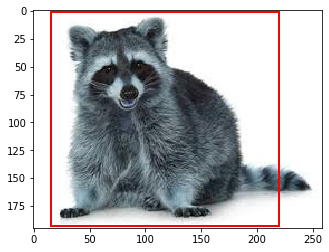

In [186]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()